In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from models.model import SmallCNN
from poisoning import PoisoningAttackCNN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch

DATA_DIR = './train'
CLASSES = ['0', '1', '2']
IMG_SIZE = (32, 32) 

X = []
y = []

for class_label in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_label)
    for fname in sorted(os.listdir(class_dir)): 
        if fname.endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            img = Image.open(img_path).resize(IMG_SIZE).convert('RGB')
            img_array = np.array(img).flatten() 
            X.append(img_array)
            y.append(int(class_label))

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

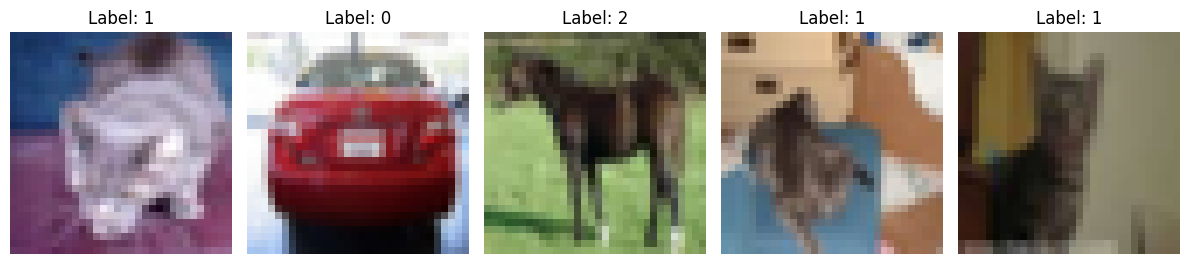

In [2]:
num_images = 5
random_indices = np.random.choice(len(X), size=num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X[idx].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'Label: {y[idx]}')
plt.tight_layout()
plt.show()

In [ ]:
target_class1=1
target_class2=2

perm1 = np.random.permutation(len(X))
X = X[perm1]
y = y[perm1]

# Ignore car class

target_class1_xdata=X[y==target_class1]
target_class2_xdata=X[y==target_class2]
target_class1_ydata=y[y==target_class1]
target_class2_ydata=y[y==target_class2]

X_train=np.concatenate([target_class1_xdata[:1500],target_class2_xdata[:1500]],axis=0)
y_train=np.concatenate([target_class1_ydata[:1500],target_class2_ydata[:1500]],axis=0)
X_val=np.concatenate([target_class1_xdata[1500:3500],target_class2_xdata[1500:3500]],axis=0)
y_val=np.concatenate([target_class1_ydata[1500:3500],target_class2_ydata[1500:3500]],axis=0)
X_test=np.concatenate([target_class1_xdata[3500:5000],target_class2_xdata[3500:5000]],axis=0)
y_test=np.concatenate([target_class1_ydata[3500:5000],target_class2_ydata[3500:5000]],axis=0)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# One-hot encoding

unique_classes = np.unique(y_train)
nb_classes = len(unique_classes)

y_train_ohe = np.zeros((len(y_train), nb_classes))
y_val_ohe=np.zeros((len(y_val), nb_classes))
y_test_ohe = np.zeros((len(X_test), nb_classes))

for i, label in enumerate(y_train):
    class_index = np.where(unique_classes == label)[0][0]
    y_train_ohe[i, class_index] = 1
for i, label in enumerate(y_val):
    class_index = np.where(unique_classes == label)[0][0]
    y_val_ohe[i, class_index] = 1
for i, label in enumerate(y_test):
    class_index = np.where(unique_classes == label)[0][0]
    y_test_ohe[i, class_index] = 1

# Convert to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_train_2class_tensor = torch.tensor(np.where(y_train == 1, 0, 1), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_val_2class_tensor = torch.tensor(np.where(y_val == 1, 0, 1), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
y_test_2class_tensor = torch.tensor(np.where(y_test == 1, 0, 1), dtype=torch.long)

y_train_ohe_tensor = torch.tensor(y_train_ohe, dtype=torch.float32)
y_val_ohe_tensor = torch.tensor(y_val_ohe, dtype=torch.float32)
y_test_ohe_tensor = torch.tensor(y_test_ohe, dtype=torch.float32)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

device = "cpu"
model = SmallCNN(num_classes=3).to(device)
X_train_3class_tensor = torch.tensor(X[:10000], dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
y_train_3class_tensor = torch.tensor(y[:10000], dtype=torch.long)
X_test_3class_tensor = torch.tensor(X[10000:15000], dtype=torch.float32).reshape(-1, 3, 32, 32) / 255.0
y_test_3class_tensor = torch.tensor(y[10000:15000], dtype=torch.long)

X_train_3class_tensor, y_train_3class_tensor = X_train_3class_tensor.to(device), y_train_3class_tensor.to(device)
X_test_3class_tensor, y_test_3class_tensor = X_test_3class_tensor.to(device), y_test_3class_tensor.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 20

model.train()
for epoch in range(epochs):
    for i in range(0, len(X_train_3class_tensor), batch_size):
        x_batch = X_train_3class_tensor[i:i+batch_size]
        y_batch = y_train_3class_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    outputs = model(X_test_3class_tensor)
    y_pred_tensor = torch.argmax(outputs, dim=1)
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test_3class_tensor.cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred)

print("Unique predictions:", np.unique(y_pred, return_counts=True))
print("Accuracy: {:.2%}".format(accuracy))


Unique predictions: (array([0, 1, 2]), array([1710, 1364, 1926]))
Accuracy: 80.42%


In [5]:
device = "cpu"
model = SmallCNN(num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
# X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 20

model.train()
for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_2class_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred_tensor = torch.argmax(outputs, dim=1)
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test_2class_tensor.cpu().numpy()
    accuracy = accuracy_score(y_true, y_pred)

print("Unique predictions:", np.unique(y_pred, return_counts=True))
print("Unique in y_train:", np.unique(y_train, return_counts=True))
print("Accuracy: {:.2%}".format(accuracy))

Unique predictions: (array([0, 1]), array([1768, 1232]))
Unique in y_train: (array([1, 2], dtype=uint8), array([1500, 1500]))
Accuracy: 78.47%


In [ ]:
def get_adversarial_examples(x_train, y_train, x_val, y_val, attack_idx):
    if y_train.ndim > 1:
        y_train_idx = torch.argmax(y_train, dim=1)
        y_val_idx = torch.argmax(y_val, dim=1)
    else:
        y_train_idx = y_train
        y_val_idx = y_val

    # Target label = flipped label
    true_label = y_train_idx[attack_idx].item()
    target_label = 1 - true_label
    target_label_tensor = torch.tensor([target_label], dtype=torch.long)

    x_init = x_train[attack_idx:attack_idx+1]

    poison_attack = PoisoningAttackCNN(
        model=SmallCNN(num_classes=2),
        x_train=x_train,
        y_train=y_train_idx,
        x_val=x_val,
        y_val=y_val_idx,
        lr=0.01,
        eps=1e-4,
        max_iter=50,
        train_steps=5,
        device='cpu'
    )

    x_poisoned = poison_attack.poison(x_init, target_label_tensor)
    return x_poisoned, target_label_tensor

import secrets
import string

def generate_hash(length=10):
    chars = string.ascii_letters + string.digits
    return ''.join(secrets.choice(chars) for _ in range(length))

def save_single_poisoned_image(img, label, index, save_dir="./poisoned"):
    os.makedirs(save_dir, exist_ok=True)

    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()

    if img.ndim == 4:
        img = img.squeeze(0)
    if img.ndim == 3 and img.shape[0] in [1, 3]:
        img = np.transpose(img, (1, 2, 0))

    if img.ndim == 1 and img.shape[0] == 3072:
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)

    if img.dtype in [np.float32, np.float64]:
        img = (img * 255).clip(0, 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    filename = f"{label}_{index}_{generate_hash()}.png"
    img_pil.save(os.path.join(save_dir, filename))

In [7]:
num_poisoned_samples=5
x_poison=X_train
y_poison=y_train

import numpy as np

num_poisoned_samples = 169

x_poison_list = []
y_poison_list = []

for attack_idx in range(num_poisoned_samples):
    x_poisoned, y_poisoned = get_adversarial_examples(
        X_train_tensor, y_train_ohe_tensor, X_val_tensor, y_val_ohe_tensor, attack_idx
    )

    x_img = x_poisoned.detach().reshape(32, 32, 3)
    save_single_poisoned_image(x_img, y_poisoned.item(), attack_idx)

    x_poison_list.append(x_poisoned.detach())
    y_poison_list.append(y_poisoned)

x_poison_tensor = torch.cat(x_poison_list, dim=0)
y_poison_tensor = torch.cat(y_poison_list, dim=0)


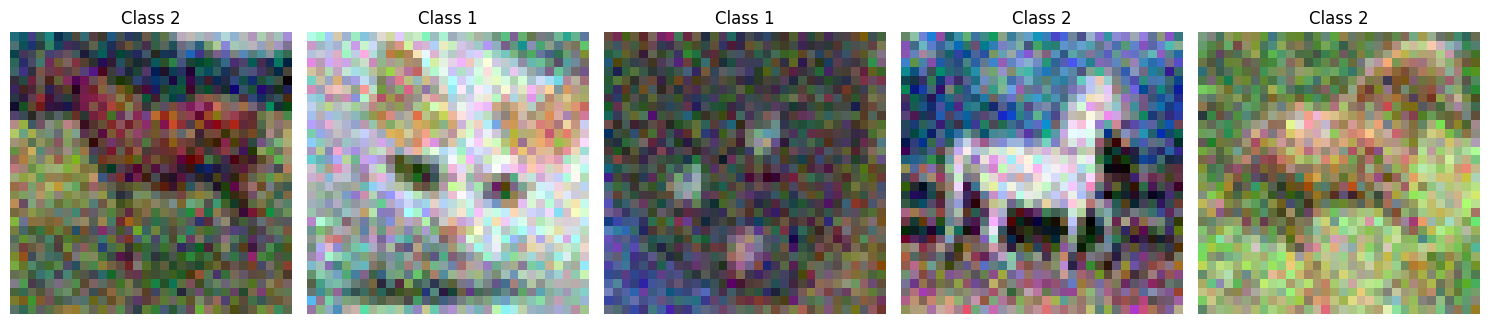

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

random_indices = np.random.choice(len(x_poison_tensor), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img_array = x_poison_tensor[idx].reshape(32, 32, 3)
    axes[i].imshow(img_array)
    axes[i].axis('off')
    axes[i].set_title(f'Class {y_train[idx]}')

for i, tensor in enumerate(x_poison_tensor):
    import secrets
    import string

    def generate_hash(length=10):
        chars = string.ascii_letters + string.digits
        return ''.join(secrets.choice(chars) for _ in range(length))
    
    save_single_poisoned_image(x_poison_tensor[i].reshape(32,32,3), y_poison_tensor[i], generate_hash(), save_dir="./poisoned/working")

plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = model(X.to(device))
        y_pred = torch.argmax(preds, dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
    return accuracy_score(y_true, y_pred)

loss_fn = nn.CrossEntropyLoss()
epochs = 200
batch_size = 64
lr = 0.001

# === Train Clean Model ===
clean_model = SmallCNN().to(device)
optimizer = torch.optim.Adam(clean_model.parameters(), lr=lr)

clean_model.train()
for epoch in range(epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        x_batch = X_train_tensor[i:i+batch_size].to(device)
        y_batch = y_train_2class_tensor[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = clean_model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

acc_clean = evaluate(clean_model, X_test_tensor, y_test_2class_tensor)

# === Train Back-Gradient Poisoned Model ===
X_train_aug = torch.cat([X_train_tensor, x_poison_tensor], dim=0)
y_train_aug = torch.cat([y_train_2class_tensor, y_poison_tensor], dim=0)

poisoned_model = SmallCNN().to(device)
optimizer = torch.optim.Adam(poisoned_model.parameters(), lr=lr)

poisoned_model.train()
for epoch in range(epochs):
    for i in range(0, len(X_train_aug), batch_size):
        x_batch = X_train_aug[i:i+batch_size].to(device)
        y_batch = y_train_aug[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = poisoned_model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

acc_poisoned = evaluate(poisoned_model, X_test_tensor, y_test_2class_tensor)

# === Train Naively Poisoned Model (5 class-0 images labeled as 1) ===
class_0_indices = (y_train_2class_tensor == 0).nonzero(as_tuple=True)[0]
mislabeled_samples = X_train_tensor[class_0_indices[:len(x_poison_list)]]
mislabeled_labels = torch.ones(len(x_poison_list), dtype=torch.long)  # flipped to class 1

X_train_naive = torch.cat([X_train_tensor, mislabeled_samples], dim=0)
y_train_naive = torch.cat([y_train_2class_tensor, mislabeled_labels], dim=0)

naive_model = SmallCNN().to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=lr)

naive_model.train()
for epoch in range(epochs):
    for i in range(0, len(X_train_naive), batch_size):
        x_batch = X_train_naive[i:i+batch_size].to(device)
        y_batch = y_train_naive[i:i+batch_size].to(device)

        optimizer.zero_grad()
        outputs = naive_model(x_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

acc_naive = evaluate(naive_model, X_test_tensor, y_test_2class_tensor)

# Results (theses are very volatile)
print(f"Accuracy of clean model:          {acc_clean:.2%}")
print(f"Accuracy of back-gradient model:  {acc_poisoned:.2%}")
print(f"Accuracy of naive poisoned model: {acc_naive:.2%}")


Accuracy of clean model:          79.30%
Accuracy of back-gradient model:  79.63%
Accuracy of naive poisoned model: 77.40%
